<h1>Introduction</h1>
We want to use bayesian data analysis for extracting trends from time series of data. Our data contains monthly mean tempretures of north of Finland "Utsjoki Nuorgam" from 01/1980 to 10(2018. Fortunately, there was not many missing data. We tried different models: 1. Linear regression plus seasoanl trend. 2. Local level model plus seasoanl trend. 3. Local linear trend plus seasonal trend. During testing the first model "Linear regression plus seasoanl trend", we faced lots of warnings and Rhat which was showing the maro´cove chains had not been converged. We tried various control parameters like higher "max_treedepth" and "adapt_delta", we alsso used higher iteration like 3000 and 5000. However, non of these settings helped us. Finally, we found out using non centered paramitrization would help us. 
<br/>
We also select multiple northern stations and used them to enhance our analysis. We used monthly mean tempretures of"Utsjoki Nuorgam", "Sodankylä Tähtelä", "Salla Värriötunturi", and "Enontekiö Kilpisjärvi Kyläkeskus" from 01/1980 to 10/2018. We selected these sattions, because other stations did not have complete datasets and number of missing data was alot. Each station had one or two missing data, which was filled using linear regression before using them in our models. We used separate model and hierarchical model for this matter. The separate model seems work alright. We expected that hierarchical model would work better, however, we again faced with multiple warnings and lots of k values above 0.7. Because of that we did not manage to compare the two models. 
<br/> All the models except centered paramitrization of "linear regression plus seasonal trend" and hierarchical model have Rhat near 1 and below 1.1, which means marcov chains have been converged and estimates are reliable. Because the size of notebook became too large, we could not print "fit" and show plot_trace for all the parameters.

At first, we show the difference between centered and non-centered paramitrization for the first model "linear regression plus seasonal trend".

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import csv

In [5]:
# add utilities directory to path
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import stan_utility
import arviz as az
import pystan
import scipy
import psis
from pystan.diagnostics import check_hmc_diagnostics

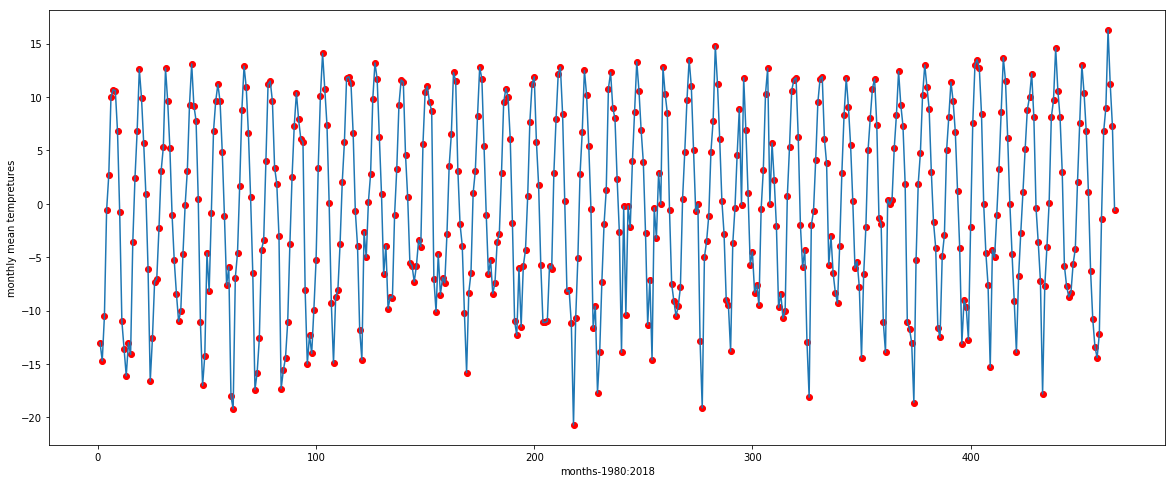

In [6]:
months=[]
tempretures=[]
count=0
for line in open('UtsjokiNuorgam_monthly_1980_2018_complete.csv'):
    if count!=0:
        try:
            tempretures.append(float(line.split(',')[3]))
            months.append(count)
        except ValueError:
            pass
    count=count+1
months=np.array(months)
tempretures=np.array(tempretures)

#shiw the data set for "Utsjoki Nuorgam" station from 1980 to 2018
fig,ax=plt.subplots(figsize=(20,8))
ax.scatter(months,tempretures,c='r')
ax.plot(months,tempretures)
ax.set_ylabel('monthly mean tempretures')
ax.set_xlabel('months-1980:2018')
plt.show()

<h2> Non-centered paramitrization: linear regression plus seasonal trend</h2>
Next session show non-centered paramitrization model of linear regression plus seasonal trend. For seasonal trend, we use period of 12 which means per year.
$$y_{t} \sim \mathcal{N}(\alpha+\beta*t+seasonal_t,sigma_1^2)$$
$$seasonal_{t+1} \sim \mathcal{N}(-\sum_{i=1}^{11}seasonal_{t-i},sigma_2^2)$$

In [7]:
with open('linear_regression_ncp_seasonal_trend.stan') as file:
    print(file.read())

functions{
  real prop_lower_zero(vector x,int T) {
	int num=0;
	for (t in 1:T){
		if (x[t]<0){
			num+=1;
		}
	}
	return num;
  }
  real prop_higher_zero(vector x,int T) {
	int num=0;
	for (t in 1:T){
		if (x[t]>0){
			num+=1;
		}
	}
	return num;
  }
  real prop_near_minus_ten(vector x,int T) {
	int num=0;
	for (t in 1:T){
		if (x[t]>-11){
			if(x[t]<-9){
				num+=1;
			}
		}
	}
	return num;
  }
}
data {
  int<lower=0> T;
  vector[T] y;
  int<lower=0> season_whithin_period;
  vector[T] x;
  real mu_alpha;  // prior mean for alpha
  real scale_alpha;   // prior std for alpha
  real mu_beta;  // prior mean for beta
  real scale_beta;   // prior std for beta
}
parameters {
vector[T] seasonal_trend_raw;
real<lower=0> tau2;
real<lower=0> sigma;
vector[11] seasonal_trend_init;
real alpha;
real beta;
}
transformed parameters {
vector[T] seasonal_trend;
vector[T] mu;
seasonal_trend[1:season_whithin_period-1]=seasonal_trend_init[1:season_whithin_period-1]+tau2*seasonal_trend_raw[1:season_whith

In [8]:
#non_centered_parameterization
import pystan
import scipy

ppf1=scipy.stats.norm.ppf((1-0.99)/2,0,1)
ppf2=scipy.stats.norm.ppf(1-((1-0.99)/2),0,1)
ratio=ppf2-ppf1
data = dict(T=months.shape[0], y=tempretures,season_whithin_period=12,x=months,
            #centerd at mean of tempretures and informative weakly prior 
            mu_alpha=np.mean(tempretures),scale_alpha=1,
            #the probability of changing (increase or decrease) weather in one year more than 0.1 is 0.01
            mu_beta=0,scale_beta=(0.2)/ratio)

model = stan_utility.compile_model('linear_regression_ncp_seasonal_trend.stan')

fit = model.sampling(data=data, seed=194838)#,iter=5000,control={'adapt_delta':0.99,'max_treedepth':20})

Using cached StanModel


Because number of parameters are alot, we could not print "fit". We use pystan dignostic to show every thing is fine. "check_hmc_diagnostics" function returns a  dictionary where each key is the name of a diagnostic check, and the value associated with each key is a Boolean value that is True if the check passed and False otherwise.

In [16]:
check_hmc_diagnostics(fit)

{'Rhat': True,
 'divergence': True,
 'energy': True,
 'n_eff': True,
 'treedepth': True}

In [12]:
stan_utility.check_treedepth(fit)
stan_utility.check_energy(fit)
stan_utility.check_div(fit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


sum of the LOO log densities:  -1163.791605130999
SE:  22.835040650877232
number of ks which are greater than 0.7:  0
estimated effective number of parameters in the model:  17.906967752284345


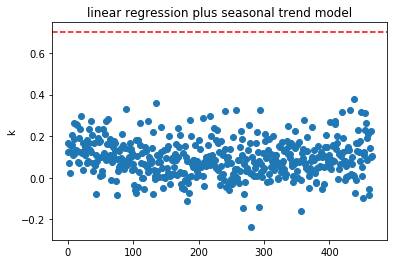

In [116]:
import psis

samples = fit.extract(permuted=True)
log_lik=samples['log_lik']
loo, loos, ks = psis.psisloo(log_lik)
m1_loo=loo
m1_loos=loos
print('sum of the LOO log densities: ',loo)
se=np.std(loos)*np.sqrt(months.shape[0])
print('SE: ',se)
count=0
for k in ks:
    if k>0.7:
        count=count+1
print('number of ks which are greater than 0.7: ',count)
lppd=np.sum (np.log (np.mean(np.exp(log_lik),axis=0)))
print('estimated effective number of parameters in the model: ',lppd-loo)
plt.scatter(np.arange(ks.shape[0]),ks)
plt.axhline(0.7, color='r',linestyle='dashed')
plt.ylabel('k')
plt.title('linear regression plus seasonal trend model')
plt.show()

Next plot showes two basic component of the time series data in which "mu" is as linear regression component,

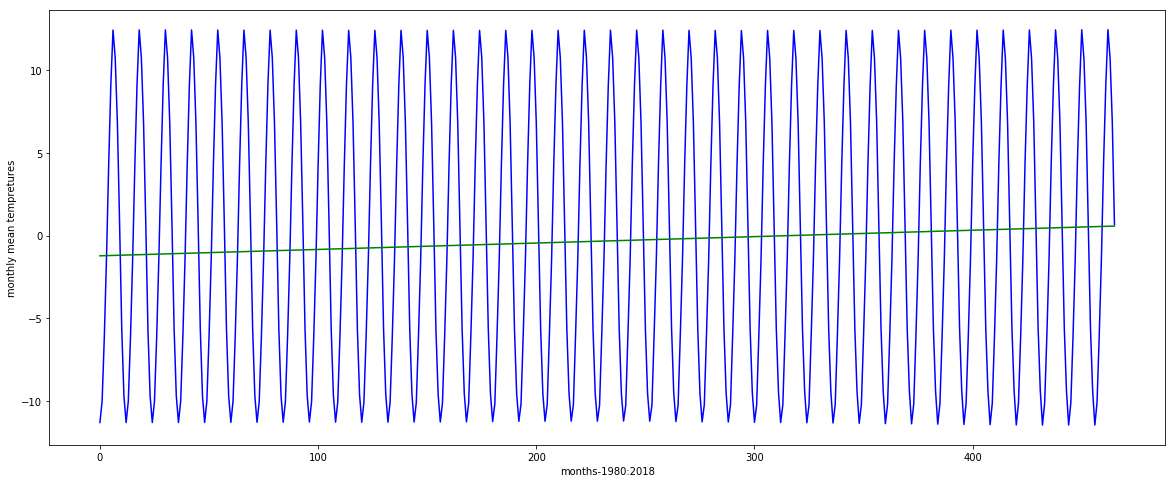

In [15]:
samples = fit.extract(permuted=True)
fig,ax=plt.subplots(figsize=(20,8))
ax.plot(np.mean(samples['seasonal_trend'],axis=0),color='b');
ax.plot(np.mean(samples['mu'],axis=0),color='g');
ax.set_ylabel('monthly mean tempretures')
ax.set_xlabel('months-1980:2018')
plt.show()

Next plot shows the original dataset in blue and sume of two component in red.

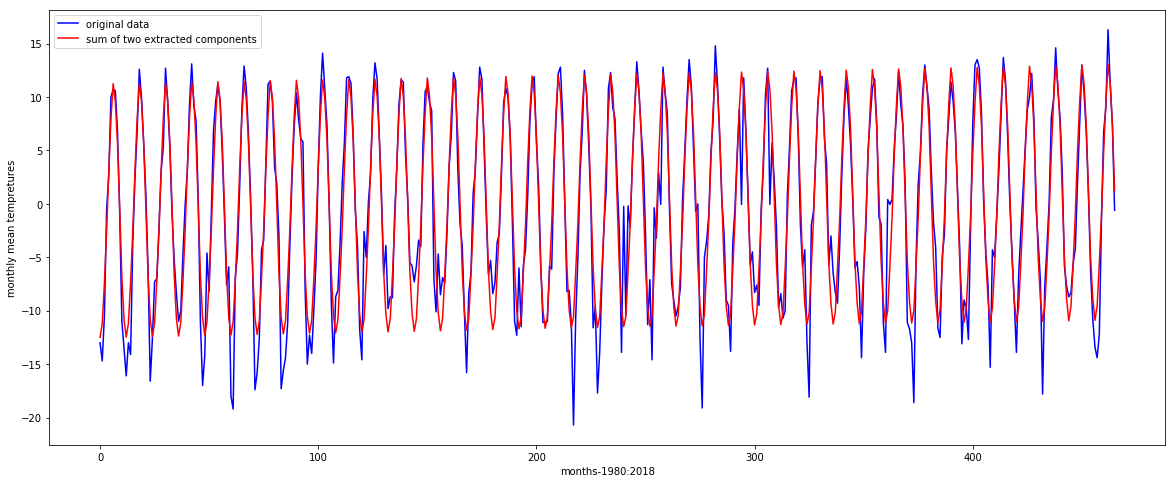

In [19]:
samples = fit.extract(permuted=True)
fig,ax=plt.subplots(figsize=(20,8))
l1,=ax.plot(tempretures,color='b');
l2,=ax.plot(np.mean(samples['seasonal_trend'],axis=0)+np.mean(samples['mu'],axis=0),color='r');
ax.set_ylabel('monthly mean tempretures')
ax.set_xlabel('months-1980:2018')
ax.legend((l1,l2),('original data','sum of two extracted components'))
plt.show()

In [9]:
inference_data = az.from_pystan(fit=fit,
                      posterior_predictive='y_hat',
                      observed_data=['y'],
                      log_likelihood='log_lik',
                      coords={'months': np.arange(months.shape[0])},
                      dims={'mu': ['months'],
                            'seasonal_trend': ['months']
                            })

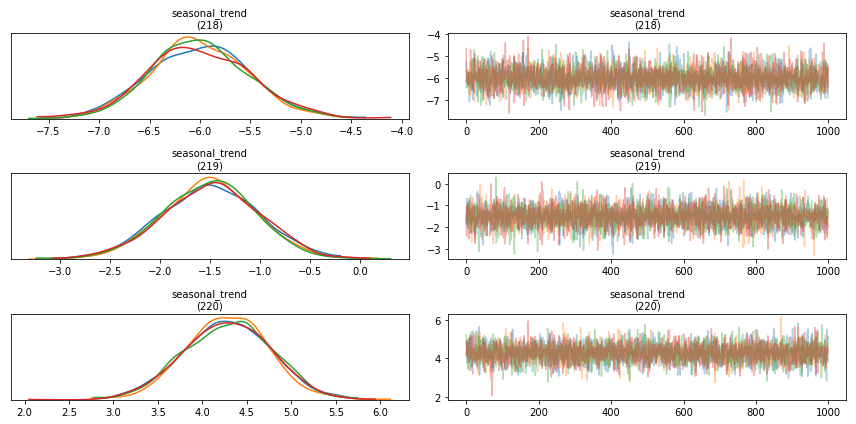

In [17]:
coords = {'months': [218,219,220]}
az.plot_trace(inference_data,var_names=['seasonal_trend'],coords=coords);
plt.show()

Next plot shows the pair plot of "seasonal trend" in months 218, 219, and 220 and the hyperparameter 'tau2' which is used as standard divition for seasonal trend. This pair plot can help us to see if there is any relation between the shape of joint distribution and the divergences (for example in the case of funnel, when the divergences gathered in a tight spot). It helps us to find out what is the reason of low energy and which parameters are weakely identifiable. Here we do not have the problem of low bfmi or divergence as plots show this.

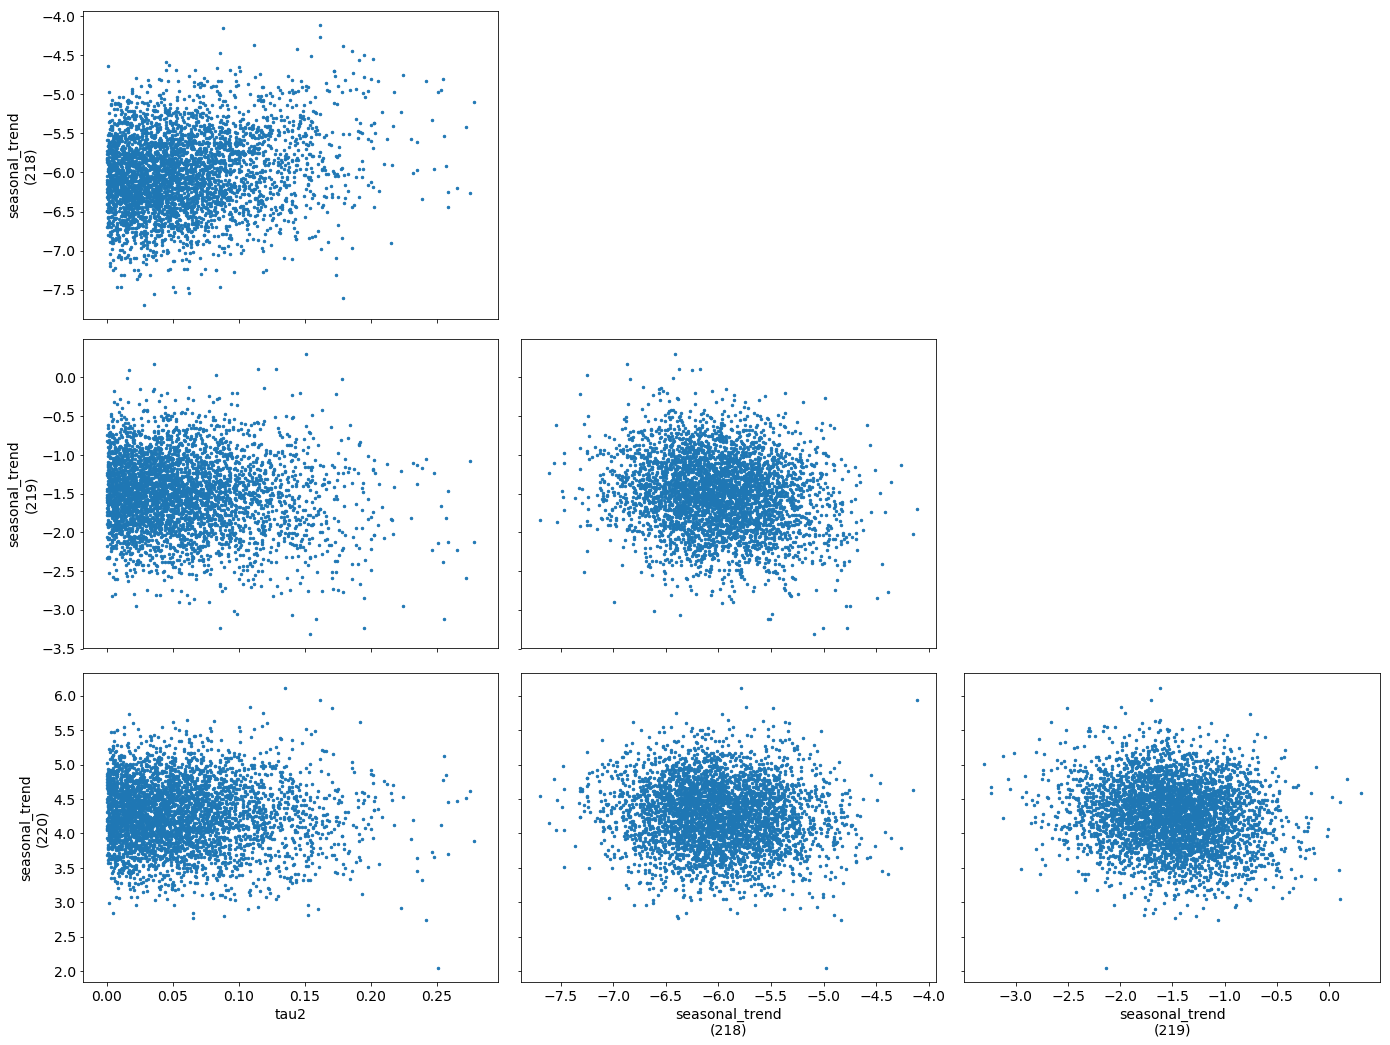

In [23]:
coords = {'months': [218,219,220]}
az.plot_pair(inference_data, var_names=[ 'tau2','seasonal_trend'],coords=coords,  divergences=True, textsize=14)
plt.show()

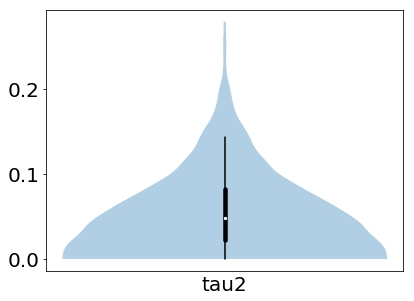

In [37]:
az.plot_violin(inference_data, var_names=['tau2'])
plt.show()

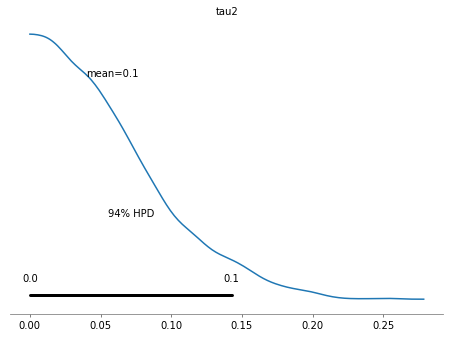

In [41]:
az.plot_posterior(inference_data, var_names=['tau2'])
plt.show()

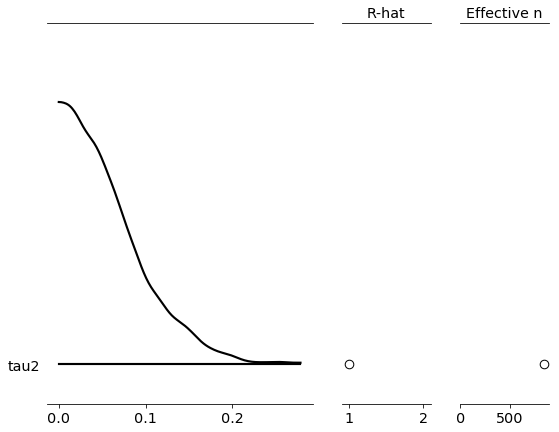

In [35]:
fig, axes = az.plot_forest(inference_data,
                           kind='ridgeplot',
                           var_names=['tau2'],
                           combined=True,
                           ridgeplot_overlap=3,
                           colors='white',
                           figsize=(9, 7))
plt.show()

Next plot shows that we do not have the problem of low energy.

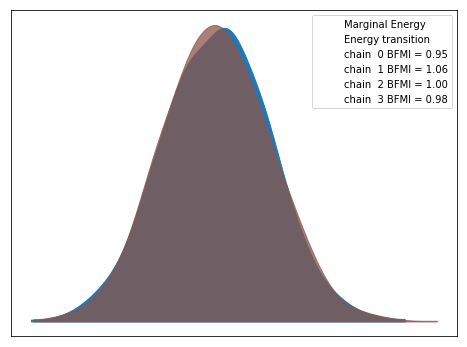

In [45]:
az.plot_energy(inference_data, figsize=(8, 6))
plt.show()

We also did posterior predictive checking as follows. It shows that our model was not able to capture the original data prefectly especially around minus ten. Next three plots show the result of the posterior predictive checking.

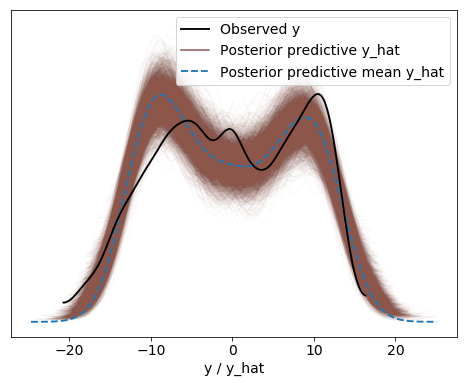

In [46]:
#Posterior Predictive Check Plot
az.plot_ppc(inference_data, alpha=0.03, figsize=(8, 6), textsize=14,data_pairs={'y' : 'y_hat'})
plt.show()

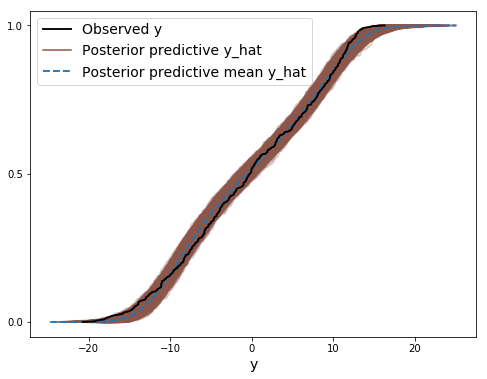

In [47]:
az.plot_ppc(inference_data, alpha=0.3, kind='cumulative', figsize=(8, 6), textsize=14,data_pairs={'y' : 'y_hat'})
plt.show()

Next plot shows different statistics of posterior predictive (histogram) and the true value (in red). As you can see, minimum, maximum and number of data around minus ten have not been predicted well enough.

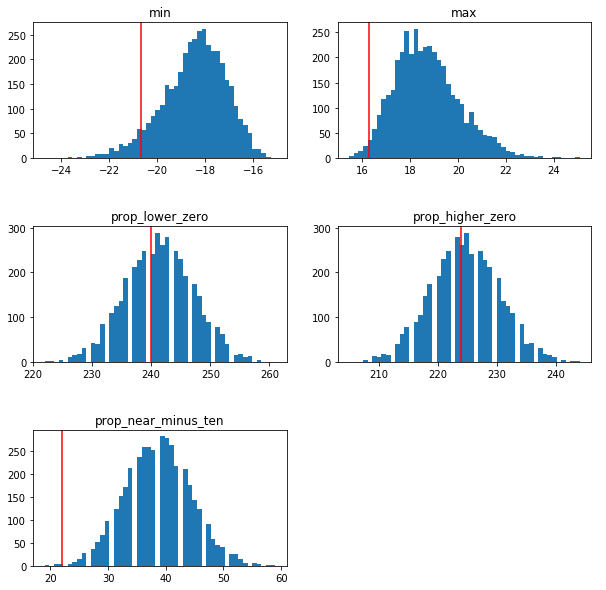

In [55]:
num_higher_zeros=0
num_lower_zeros=0
num_near_minus_ten=0
for t in tempretures:
    if t>0:
        num_higher_zeros=num_higher_zeros+1
    if t<0:
        num_lower_zeros=num_lower_zeros+1
    if t>-11 and t<-9:
        num_near_minus_ten=num_near_minus_ten+1
fig,axes=plt.subplots(3,2,figsize=(10,10))
samples = fit.extract(permuted=True)
axes[0,0].hist(samples['y_hat_min'],bins=50)
axes[0,0].axvline(np.min(tempretures),color='r')
axes[0,0].set_title('min')
axes[0,1].hist(samples['y_hat_max'],bins=50)
axes[0,1].axvline(np.max(tempretures),color='r')
axes[0,1].set_title('max')
axes[1,0].hist(samples['y_hat_prop_lower_zero'],bins=50)
axes[1,0].axvline(num_lower_zeros,color='r')
axes[1,0].set_title('prop_lower_zero')
axes[1,1].hist(samples['y_hat_prop_higher_zero'],bins=50)
axes[1,1].axvline(num_higher_zeros,color='r')
axes[1,1].set_title('prop_higher_zero')
axes[2,0].hist(samples['y_hat_prop_near_minus_ten'],bins=50)
axes[2,0].axvline(num_near_minus_ten,color='r')
axes[2,0].set_title('prop_near_minus_ten')
axes[2,1].set_axis_off()
plt.subplots_adjust(hspace=0.5)
plt.show()

<h2> Centered paramitrization: linear regression plus seasonal trend</h2>
Next section showes that with centerd paramitrization we have Rhat more that 1.1 for some parameters and low bfmi value. In this model seasonal trend is defined in the model part of stan code.

In [18]:
with open('linear_regression_cp_seasonal_trend.stan') as file:
    print(file.read())

data {
  int<lower=0> T;
  vector[T] y;
  int<lower=0> season_whithin_period;
  vector[T] x;
  real mu_alpha;  // prior mean for alpha
  real scale_alpha;   // prior std for alpha
  real mu_beta;  // prior mean for beta
  real scale_beta;   // prior std for beta
}
parameters {
vector[T] seasonal_trend;
real<lower=0> tau2;
real<lower=0> sigma;
vector[11] seasonal_trend_init;
real alpha;
real beta;
}
transformed parameters {
vector[T] mu;
mu=alpha+beta*x;
}
model {
seasonal_trend[1:season_whithin_period-1] ~ normal(seasonal_trend_init[1:season_whithin_period-1], tau2);
for (i in season_whithin_period:T){
	seasonal_trend[i] ~ normal(-seasonal_trend[i-1]-seasonal_trend[i-2]-seasonal_trend[i-3]-seasonal_trend[i-4]-seasonal_trend[i-5]-seasonal_trend[i-6]-seasonal_trend[i-7]-seasonal_trend[i-8]-seasonal_trend[i-9]-seasonal_trend[i-10]-seasonal_trend[i-11], tau2);
	}

	
for (t in 1:T)
    y[t] ~ normal(mu[t]+seasonal_trend[t],sigma);
// hyperparameters
tau2 ~ cauchy(0, 4);// weakly informative

In [26]:
#centered_parameterization
import pystan
import scipy
ppf1=scipy.stats.norm.ppf((1-0.99)/2,0,1)
ppf2=scipy.stats.norm.ppf(1-((1-0.99)/2),0,1)
ratio=ppf2-ppf1
data2 = dict(T=months.shape[0], y=tempretures,season_whithin_period=12,x=months,
             mu_alpha=np.mean(tempretures),scale_alpha=1,mu_beta=0,scale_beta=(0.2)/ratio)

model2 = stan_utility.compile_model('linear_regression_cp_seasonal_trend.stan')

#fit = model.sampling(data=data,control={'adapt_delta':0.99}, seed=194838)
fit2 = model2.sampling(data=data2, seed=194838,control={'max_treedepth':15})#,iter=3000,control={'max_treedepth':15})#,iter=5000,control={'adapt_delta':0.99,'max_treedepth':20})

Using cached StanModel


In [41]:
check_hmc_diagnostics(fit2,verbose=False)

{'Rhat': False,
 'divergence': True,
 'energy': False,
 'n_eff': True,
 'treedepth': False}

In [28]:
stan_utility.check_treedepth(fit2)
stan_utility.check_energy(fit2)
stan_utility.check_div(fit2)

436 of 4000 iterations saturated the maximum tree depth of 10 (10.9%)
Run again with max_depth set to a larger value to avoid saturation
Chain 0: E-BFMI = 0.013153221027149374
E-BFMI below 0.2 indicates you may need to reparameterize your model
Chain 1: E-BFMI = 0.013619942723829118
E-BFMI below 0.2 indicates you may need to reparameterize your model
Chain 2: E-BFMI = 0.014873749456353091
E-BFMI below 0.2 indicates you may need to reparameterize your model
Chain 3: E-BFMI = 0.006857007269303362
E-BFMI below 0.2 indicates you may need to reparameterize your model
0.0 of 4000 iterations ended with a divergence (0.0%)


In [29]:
inference_data2 = az.from_pystan(fit=fit2,
                      posterior_predictive='y_hat',
                      observed_data=['y'],
                      log_likelihood='log_lik',
                      coords={'months': np.arange(months.shape[0])},
                      dims={'mu': ['months'],
                            'seasonal_trend': ['months']
                            })

Next plot pair shows concentration of joint distribution of "tau2" and "seasonal_trend" on two parts which means we have some problem with our model.

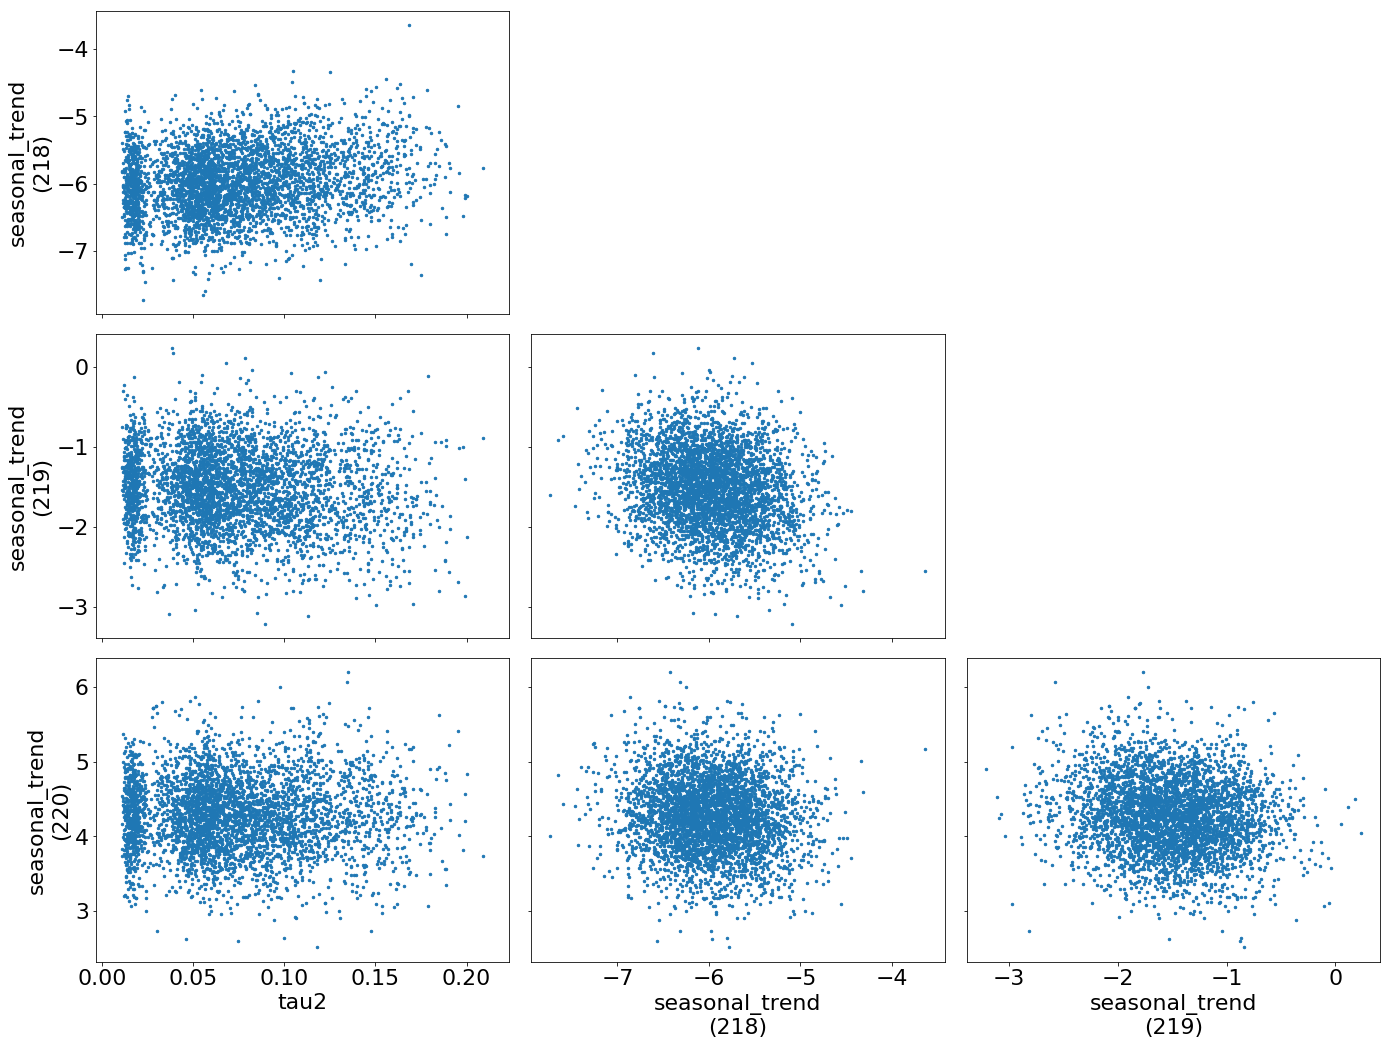

In [30]:
coords = {'months': [218,219,220]}
az.plot_pair(inference_data2, var_names=[ 'tau2','seasonal_trend'],coords=coords,  divergences=True, textsize=22)
plt.show()

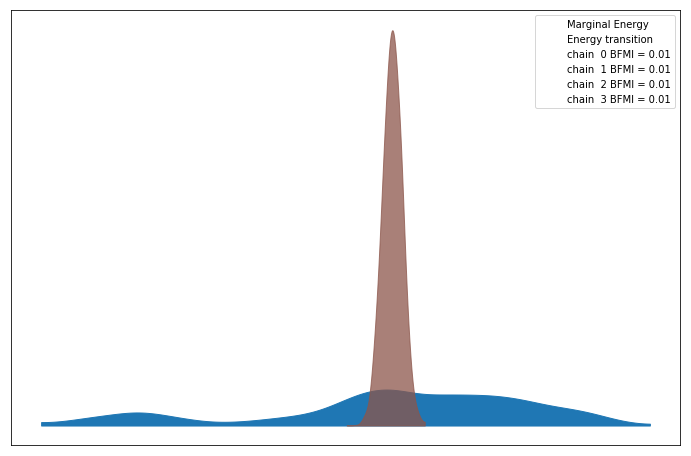

In [31]:
az.plot_energy(inference_data2, figsize=(12, 8))
plt.show()

<h2>Prior sensitivity analysis for the first model "linear regression plus seasonal trend" with non-centered paramitrization</h2> 

In [1]:
#Super-weak prior on alpha
data_super_weak = dict(T=months.shape[0], y=tempretures,season_whithin_period=12,x=months,
            mu_alpha=0,scale_alpha=100,mu_beta=0,scale_beta=(0.2)/ratio)
model_super_weak = stan_utility.compile_model('linear_regression_ncp_seasonal_trend.stan')
fit_super_weak = model_super_weak.sampling(data=data_super_weak, seed=194838,control={'adapt_delta':0.9})

#Uniform prior on alpha
data_uniform = dict(T=months.shape[0], y=tempretures,season_whithin_period=12,x=months,mu_beta=0,scale_beta=(0.2)/ratio)
model_uniform = stan_utility.compile_model('linear_regression_ncp_seasonal_trend_uniform_prior.stan')
fit_uniform = model_uniform.sampling(data=data_uniform, seed=194838,control={'adapt_delta':0.9})

#Super-constraining prior on alpha
data_super_constraint = dict(T=months.shape[0], y=tempretures,season_whithin_period=12,x=months,
            mu_alpha=1.2,scale_alpha=0.1,mu_beta=0,scale_beta=(0.2)/ratio)
model_super_constraint = stan_utility.compile_model('linear_regression_ncp_seasonal_trend.stan')
fit_super_constraint = model_super_constraint.sampling(data=data_super_constraint, seed=194838,control={'adapt_delta':0.9})

#heavy-tailed weakly informative prior on alpha
data_heavy_tailed_weakly_informative = dict(T=months.shape[0], y=tempretures,season_whithin_period=12,x=months,
            mu_alpha=np.mean(tempretures),scale_alpha=1,mu_beta=0,scale_beta=(0.2)/ratio)
model_heavy_tailed_weakly_informative = stan_utility.compile_model('linear_regression_ncp_seasonal_trend_cauchy_prior.stan')
fit_heavy_tailed_weakly_informative = model_heavy_tailed_weakly_informative.sampling(data=data_heavy_tailed_weakly_informative, seed=194838,control={'adapt_delta':0.9})

In next figures, you can see the result of trying different priors for the alpha (intercept) of linear regression. In only one of the settings (super constraint prior), posterior skewed towards the prior completely. In two weakly inmformative priors, posterior a little skewed towrads prior, and in super-weak prior, posterior is not different from using uniform prior. Super weak prior is used to reduce the non-identifiablity of the model. We think using weakly informative prior is better, because we are not certain about the value of intercapt, and some weakly prior helps to remove unreasonable values while reasonable values will be included.  

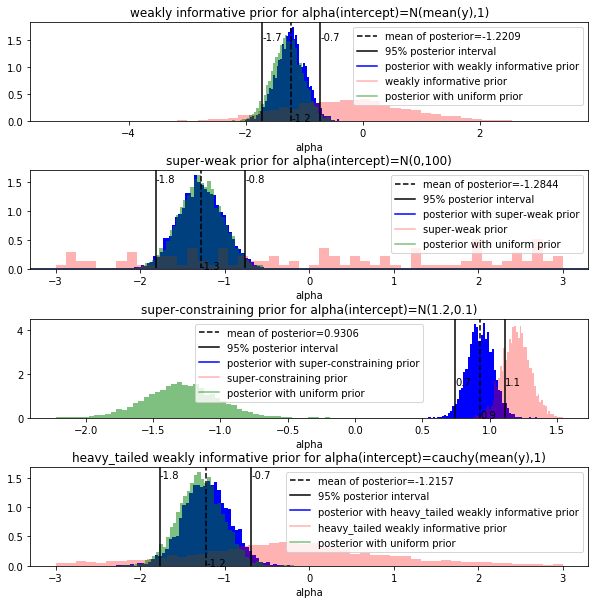

In [77]:
fig,axes=plt.subplots(4,1,figsize=(10,10))
samples3 = fit_uniform.extract(permuted=True)
samples = fit.extract(permuted=True)
x95_1=np.percentile(samples['alpha'],2.5)
x95_2=np.percentile(samples['alpha'],97.5)
l1=axes[0].axvline(np.mean(samples['alpha']),linestyle='--',color='k')
axes[0].annotate(np.round(np.mean(samples['alpha']),1), xy=(np.mean(samples['alpha']), 0))
l2=axes[0].axvline(x95_1,color='k')
axes[0].axvline(x95_2,color='k')
axes[0].annotate(np.round(x95_1,1), xy=(x95_1, 1.5))
axes[0].annotate(np.round(x95_2,1), xy=(x95_2, 1.5))
prior_alpha=scipy.stats.norm.rvs(loc=np.mean(tempretures),scale=1,size=4000)
axes[0].hist(samples['alpha'],bins=50,density=True,color='b')
axes[0].hist(prior_alpha,bins=50,density=True,alpha=0.3,color='r')
axes[0].hist(samples3['alpha'],bins=50,density=True,alpha=0.5,color='g',label='posterior with uniform prior')
axes[0].set_xlabel('alpha')
axes[0].legend((l1,l2,axes[1].axhline(0, color='b'),axes[1].axhline(0,alpha=0.3, color='r'),
                axes[1].axhline(0,alpha=0.5, color='g')),('mean of posterior='+str(np.round(np.mean(samples['alpha']),4)),
                                                          '95% posterior interval',
                                                          'posterior with weakly informative prior',
                                                          'weakly informative prior',
                                                          'posterior with uniform prior')) 
axes[0].set_title("weakly informative prior for alpha(intercept)="+"N(mean(y),1)")

samples = fit_super_weak.extract(permuted=True)
x95_1=np.percentile(samples['alpha'],2.5)
x95_2=np.percentile(samples['alpha'],97.5)
l1=axes[1].axvline(np.mean(samples['alpha']),linestyle='--',color='k')
axes[1].annotate(np.round(np.mean(samples['alpha']),1), xy=(np.mean(samples['alpha']), 0))
l2=axes[1].axvline(x95_1,color='k')
axes[1].axvline(x95_2,color='k')
axes[1].annotate(np.round(x95_1,1), xy=(x95_1, 1.5))
axes[1].annotate(np.round(x95_2,1), xy=(x95_2, 1.5))
prior_alpha=scipy.stats.norm.rvs(loc=0,scale=100,size=4000)
axes[1].hist(samples['alpha'],bins=50,density=True,color='b')
axes[1].hist(prior_alpha,bins=50,range=(-3,3),density=True,alpha=0.3,color='r')
axes[1].hist(samples3['alpha'],bins=50,density=True,alpha=0.5,color='g')
axes[1].set_xlabel('alpha')
axes[1].legend((l1,l2,axes[1].axhline(0, color='b'),axes[1].axhline(0,alpha=0.3, color='r'),
                axes[1].axhline(0,alpha=0.5, color='g')),('mean of posterior='+str(np.round(np.mean(samples['alpha']),4)),
                                                          '95% posterior interval',
                                                          'posterior with super-weak prior',
                                                          'super-weak prior',
                                                          'posterior with uniform prior')) 
axes[1].set_title("super-weak prior for alpha(intercept)="+"N(0,100)")

samples = fit_super_constraint.extract(permuted=True)
x95_1=np.percentile(samples['alpha'],2.5)
x95_2=np.percentile(samples['alpha'],97.5)
l1=axes[2].axvline(np.mean(samples['alpha']),linestyle='--',color='k')
axes[2].annotate(np.round(np.mean(samples['alpha']),1), xy=(np.mean(samples['alpha']), 0))
l2=axes[2].axvline(x95_1,color='k')
axes[2].axvline(x95_2,color='k')
axes[2].annotate(np.round(x95_1,1), xy=(x95_1, 1.5))
axes[2].annotate(np.round(x95_2,1), xy=(x95_2, 1.5))
prior_alpha=scipy.stats.norm.rvs(loc=1.2,scale=0.1,size=4000)
axes[2].hist(samples['alpha'],bins=50,density=True,color='b')
axes[2].hist(prior_alpha,bins=50,density=True,alpha=0.3,color='r')
axes[2].hist(samples3['alpha'],bins=50,density=True,alpha=0.5,color='g',label='posterior with uniform prior')
axes[2].set_xlabel('alpha')
axes[2].legend((l1,l2,axes[1].axhline(0, color='b'),axes[1].axhline(0,alpha=0.3, color='r'),
                axes[1].axhline(0,alpha=0.5, color='g')),('mean of posterior='+str(np.round(np.mean(samples['alpha']),4)),
                                                          '95% posterior interval',
                                                          'posterior with super-constraining prior',
                                                          'super-constraining prior',
                                                          'posterior with uniform prior')) 
axes[2].set_title("super-constraining prior for alpha(intercept)="+"N(1.2,0.1)")

samples = fit_heavy_tailed_weakly_informative.extract(permuted=True)
x95_1=np.percentile(samples['alpha'],2.5)
x95_2=np.percentile(samples['alpha'],97.5)
l1=axes[3].axvline(np.mean(samples['alpha']),linestyle='--',color='k')
axes[3].annotate(np.round(np.mean(samples['alpha']),1), xy=(np.mean(samples['alpha']), 0))
l2=axes[3].axvline(x95_1,color='k')
axes[3].axvline(x95_2,color='k')
axes[3].annotate(np.round(x95_1,1), xy=(x95_1, 1.5))
axes[3].annotate(np.round(x95_2,1), xy=(x95_2, 1.5))
prior_alpha=scipy.stats.cauchy.rvs(loc=np.mean(tempretures),scale=1,size=4000)
axes[3].hist(samples['alpha'],bins=50,density=True,color='b')
axes[3].hist(prior_alpha,bins=50,range=(-3,3),density=True,alpha=0.3,color='r')
axes[3].hist(samples3['alpha'],bins=50,density=True,alpha=0.5,color='g',label='posterior with uniform prior')
axes[3].set_xlabel('alpha')
axes[3].legend((l1,l2,axes[1].axhline(0, color='b'),axes[1].axhline(0,alpha=0.3, color='r'),
                axes[1].axhline(0,alpha=0.5, color='g')),('mean of posterior='+str(np.round(np.mean(samples['alpha']),4)),
                                                          '95% posterior interval',
                                                          'posterior with heavy_tailed weakly informative prior',
                                                          'heavy_tailed weakly informative prior',
                                                          'posterior with uniform prior')) 
axes[3].set_title("heavy_tailed weakly informative prior for alpha(intercept)="+"cauchy(mean(y),1)")
plt.subplots_adjust(hspace=0.5)
plt.show()

<h2>Prediction of weather from 01/2018 until 10/2018 using the first model "linear regression plus seasonal trend" and the data from 1980 to 2017</h2> 

In [21]:
with open('linear_regression_ncp_seasonal_trend_predict2018.stan') as file:
    print(file.read())

data {
  int<lower=0> T;
  vector[T] y;
  int<lower=0> season_whithin_period;
  //vector[T] x;
  int<lower=0> T_pred;
  vector[T+T_pred] x;
  real mu_alpha;  // prior mean for alpha
  real scale_alpha;   // prior std for alpha
  real mu_beta;  // prior mean for beta
  real scale_beta;   // prior std for beta
}
parameters {
vector[T+T_pred] seasonal_trend_raw;
real<lower=0> tau2;
real<lower=0> sigma;
vector[11] seasonal_trend_init;
real alpha;
real beta;
}
transformed parameters {
vector[T+T_pred] seasonal_trend;
vector[T+T_pred] mu;
seasonal_trend[1:season_whithin_period-1]=seasonal_trend_init[1:season_whithin_period-1]+tau2*seasonal_trend_raw[1:season_whithin_period-1];
for (i in season_whithin_period:T+T_pred){
	seasonal_trend[i] = -seasonal_trend[i-1]-seasonal_trend[i-2]-seasonal_trend[i-3]-seasonal_trend[i-4]-seasonal_trend[i-5]-seasonal_trend[i-6]-seasonal_trend[i-7]-seasonal_trend[i-8]-seasonal_trend[i-9]-seasonal_trend[i-10]-seasonal_trend[i-11]+ tau2*seasonal_trend_raw[i];
	}
m

In [79]:
ppf1=scipy.stats.norm.ppf((1-0.99)/2,0,1)
ppf2=scipy.stats.norm.ppf(1-((1-0.99)/2),0,1)
ratio=ppf2-ppf1
data_ahead = dict(T=months.shape[0]-10, y=tempretures[:-10],season_whithin_period=12,x=months,T_pred=10,
            mu_alpha=np.mean(tempretures),scale_alpha=1,mu_beta=0,scale_beta=(0.2)/ratio)

model_ahead = stan_utility.compile_model('linear_regression_ncp_seasonal_trend_predict2018.stan')

fit_ahead = model_ahead.sampling(data=data_ahead, seed=194838)

Using cached StanModel


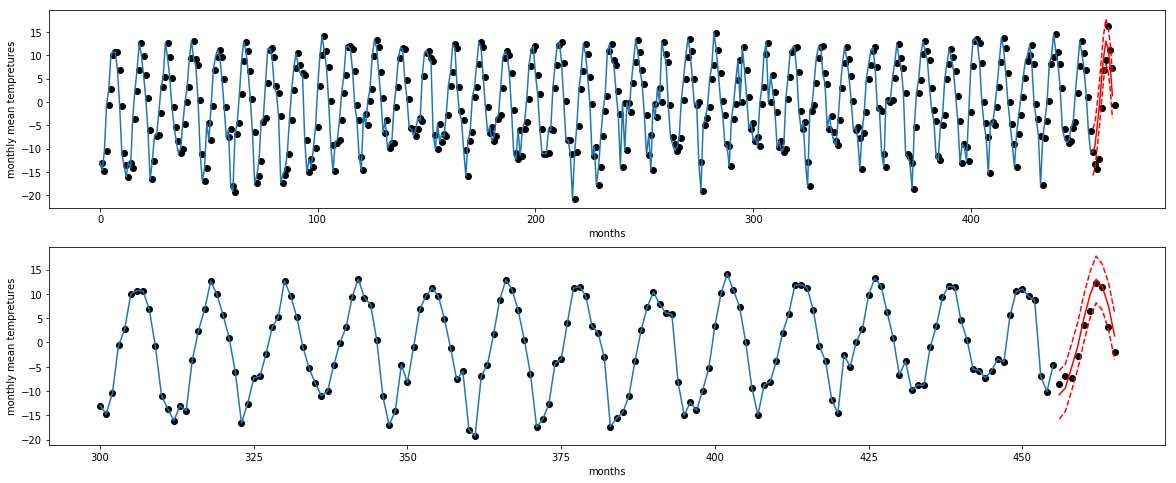

In [80]:
samples = fit_ahead.extract(permuted=True)
y=tempretures[:-10]
fig,axes=plt.subplots(2,1,figsize=(20,8))
axes[0].scatter(months,tempretures,color='K')
axes[0].plot(np.arange(0,months.shape[0]-10),y)
axes[0].plot(np.arange(months.shape[0]-10,months.shape[0]),np.mean(samples['y_pred'],axis=0),'r')
axes[0].plot(np.arange(months.shape[0]-10,months.shape[0]),np.percentile(samples['y_pred'], 5, axis=0),color='r',linestyle='dashed')
axes[0].plot(np.arange(months.shape[0]-10,months.shape[0]),np.percentile(samples['y_pred'], 95, axis=0),color='r',linestyle='dashed')
axes[0].set_ylabel('monthly mean tempretures')
axes[0].set_xlabel('months')

axes[1].scatter(np.arange(300,months.shape[0]),tempretures[:-300],color='K')
axes[1].plot(np.arange(300,months.shape[0]-10),tempretures[:-300-10])
axes[1].plot(np.arange(months.shape[0]-10,months.shape[0]),np.mean(samples['y_pred'],axis=0),'r')
axes[1].plot(np.arange(months.shape[0]-10,months.shape[0]),np.percentile(samples['y_pred'], 5, axis=0),color='r',linestyle='dashed')
axes[1].plot(np.arange(months.shape[0]-10,months.shape[0]),np.percentile(samples['y_pred'], 95, axis=0),color='r',linestyle='dashed')
axes[1].set_ylabel('monthly mean tempretures')
axes[1].set_xlabel('months')
plt.show()

<h2>Local level model (random walk plus noise)</h2>
In this model the seasoanl part is the same as before, but instead of linear regression we used local level model. Like before, AR(11) used for seasonal trend.
$$y_t \sim \mathcal{N}(\mu_t,sigma_1^2)$$
$$mu_{t+1} \sim \mathcal{N}(\mu_{t},sigma_2^2)$$
$$seasonal_{t+1} \sim \mathcal{N}(-\sum_{i=1}^{11}seasonal_{t-i},sigma_2^2)$$

In [22]:
with open('npc_local_level_seasonal_trend.stan') as file:
    print(file.read())

data {
  int<lower=0> T;
  vector[T] y;
  int<lower=0> season_whithin_period;
}
parameters {
vector[T] seasonal_trend_raw;
vector[T] mu_raw;
real<lower=0> tau2;
real<lower=0> tau3;
real<lower=0> sigma;
vector[11] seasonal_trend_init;
real mu_init;
}
transformed parameters {
vector[T] seasonal_trend;
vector[T] mu;
seasonal_trend[1:season_whithin_period-1]=seasonal_trend_init[1:season_whithin_period-1]+tau2*seasonal_trend_raw[1:season_whithin_period-1];
for (i in season_whithin_period:T){
	seasonal_trend[i] = -seasonal_trend[i-1]-seasonal_trend[i-2]-seasonal_trend[i-3]-seasonal_trend[i-4]-seasonal_trend[i-5]-seasonal_trend[i-6]-seasonal_trend[i-7]-seasonal_trend[i-8]-seasonal_trend[i-9]-seasonal_trend[i-10]-seasonal_trend[i-11]+ tau2*seasonal_trend_raw[i];
	}
mu[1]=mu_init+tau3*mu_raw[1];
for (t in 2:T)
	mu[t] =mu[t-1]+tau3*mu_raw[t];
}
model {
for (t in 1:T)
    y[t] ~ normal(mu[t]+seasonal_trend[t],sigma);
// hyperparameters
tau2 ~ cauchy(0, 4);// weakly informative prior
tau3 ~ cauchy

In [81]:
data_local_level = dict(T=months.shape[0], y=tempretures,season_whithin_period=12)

model_local_level = stan_utility.compile_model('npc_local_level_seasonal_trend.stan')

fit_local_level = model_local_level.sampling(data=data_local_level, seed=194838,control={'adapt_delta':0.99})

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dcb92305843a89fca94f2a9f281316ba NOW.
C:\ProgramData\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\roohis1\AppData\Local\Temp\tmpjerbj3y6\stanfit4anon_model_dcb92305843a89fca94f2a9f281316ba_6613446067122760211.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [42]:
check_hmc_diagnostics(fit_local_level)

{'Rhat': True,
 'divergence': True,
 'energy': True,
 'n_eff': True,
 'treedepth': True}

In [83]:
stan_utility.check_treedepth(fit_local_level)
stan_utility.check_energy(fit_local_level)
stan_utility.check_div(fit_local_level)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


sum of the LOO log densities:  -1162.8808717421175
SE:  23.14487010687774
number of ks which are greater than 0.7:  0
estimated effective number of parameters in the model:  25.714604975603606


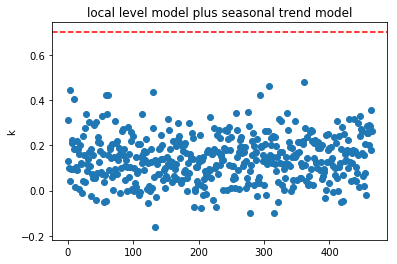

In [85]:
import psis

samples = fit_local_level.extract(permuted=True)
log_lik=samples['log_lik']
loo, loos, ks = psis.psisloo(log_lik)
m2_loo=loo
m2_loos=loos
print('sum of the LOO log densities: ',loo)
se=np.std(loos)*np.sqrt(months.shape[0])
print('SE: ',se)
count=0
for k in ks:
    if k>0.7:
        count=count+1
print('number of ks which are greater than 0.7: ',count)
lppd=np.sum (np.log (np.mean(np.exp(log_lik),axis=0)))
print('estimated effective number of parameters in the model: ',lppd-loo)
plt.scatter(np.arange(ks.shape[0]),ks)
plt.axhline(0.7, color='r',linestyle='dashed')
plt.ylabel('k')
plt.title('local level model plus seasonal trend model')
plt.show()

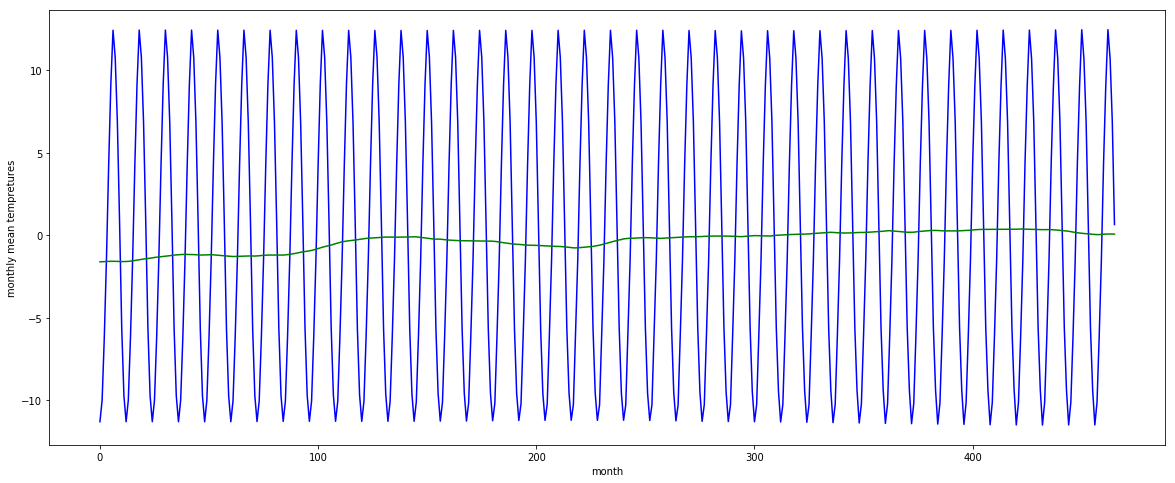

In [86]:
samples = fit_local_level.extract(permuted=True)
fig,ax=plt.subplots(figsize=(20,8))
ax.plot(np.mean(samples['seasonal_trend'],axis=0),color='b');
ax.plot(np.mean(samples['mu'],axis=0),color='g');
ax.set_ylabel('monthly mean tempretures')
ax.set_xlabel('month')
plt.show()

In [87]:
inference_data_local_level = az.from_pystan(fit=fit_local_level,
                      posterior_predictive='y_hat',
                      observed_data=['y'],
                      log_likelihood='log_lik',
                      coords={'months': np.arange(months.shape[0])},
                      dims={'mu': ['months'],
                             'seasonal_trend': ['months']
                            })

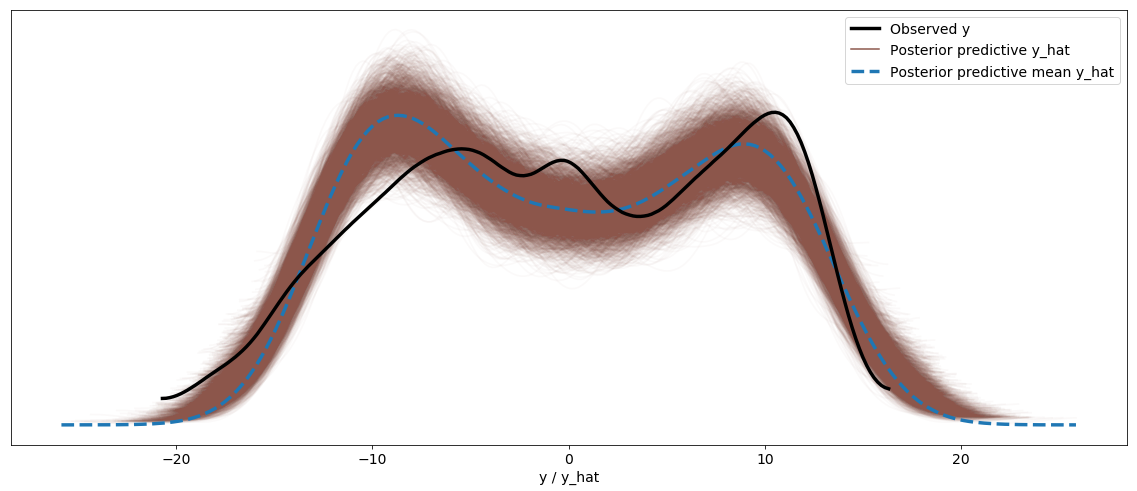

In [92]:
#Posterior Predictive Check Plot
az.plot_ppc(inference_data_local_level, alpha=0.03, figsize=(20, 8), textsize=14,data_pairs={'y' : 'y_hat'})
plt.show()

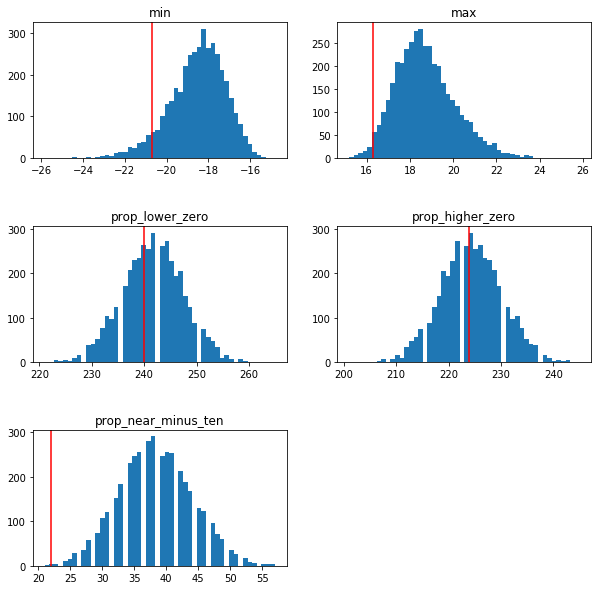

In [94]:
num_higher_zeros=0
num_lower_zeros=0
num_near_minus_ten=0
for t in tempretures:
    if t>0:
        num_higher_zeros=num_higher_zeros+1
    if t<0:
        num_lower_zeros=num_lower_zeros+1
    if t>-11 and t<-9:
        num_near_minus_ten=num_near_minus_ten+1
fig,axes=plt.subplots(3,2,figsize=(10,10))
samples = fit_local_level.extract(permuted=True)
axes[0,0].hist(samples['y_hat_min'],bins=50)
axes[0,0].axvline(np.min(tempretures),color='r')
axes[0,0].set_title('min')
axes[0,1].hist(samples['y_hat_max'],bins=50)
axes[0,1].axvline(np.max(tempretures),color='r')
axes[0,1].set_title('max')
axes[1,0].hist(samples['y_hat_prop_lower_zero'],bins=50)
axes[1,0].axvline(num_lower_zeros,color='r')
axes[1,0].set_title('prop_lower_zero')
axes[1,1].hist(samples['y_hat_prop_higher_zero'],bins=50)
axes[1,1].axvline(num_higher_zeros,color='r')
axes[1,1].set_title('prop_higher_zero')
axes[2,0].hist(samples['y_hat_prop_near_minus_ten'],bins=50)
axes[2,0].axvline(num_near_minus_ten,color='r')
axes[2,0].set_title('prop_near_minus_ten')
axes[2,1].set_axis_off()
plt.subplots_adjust(hspace=0.5)
plt.show()

<h2>Local linear trend</h2>
In this model the seasoanl part is the same as before, but instead of linear regression or local level model we used local linear trend. Name on the model is linear trend because it used $$\delta_t$$ as a slope with $$\Delta t=1$$
This model is able to capture trending in particular direction (continuous increase or decrease).  
$$y_t \sim \mathcal{N}(\mu_t+seasonal_t,sigma_1^2)$$
$$\mu_{t+1} \sim \mathcal{N}(\mu_{t}+\delta_{t},sigma_2^2)$$
$$\delta_{t+1} \sim \mathcal{N}(\delta_{t},sigma_3^2)$$
$$seasonal_{t+1} \sim \mathcal{N}(-\sum_{i=1}^{11}seasonal_{t-i},sigma_4^2)$$

In [23]:
with open('npc_linear_trend_seasonal_trend.stan') as file:
    print(file.read())

data {
  int<lower=0> T;
  vector[T] y;
  int<lower=0> season_whithin_period;
}
parameters {
vector[T] delta_raw;
vector[T] seasonal_trend_raw;
vector[T] linear_trend_raw;
real<lower=0> tau1;
real<lower=0> tau2;
real<lower=0> tau3;
real<lower=0> sigma;
vector[11] seasonal_trend_init;
real linear_trend_init;
real delta_init;
}
transformed parameters {
vector[T] seasonal_trend;
vector[T] linear_trend;
vector[T] delta;
seasonal_trend[1:season_whithin_period-1]=seasonal_trend_init[1:season_whithin_period-1]+tau2*seasonal_trend_raw[1:season_whithin_period-1];
for (i in season_whithin_period:T){
	seasonal_trend[i] = -seasonal_trend[i-1]-seasonal_trend[i-2]-seasonal_trend[i-3]-seasonal_trend[i-4]-seasonal_trend[i-5]-seasonal_trend[i-6]-seasonal_trend[i-7]-seasonal_trend[i-8]-seasonal_trend[i-9]-seasonal_trend[i-10]-seasonal_trend[i-11]+ tau2*seasonal_trend_raw[i];
	}
	
delta[1]=delta_init+tau1*delta_raw[1];
for (t in 2:T)
	delta[t] =delta[t-1]+tau1*delta_raw[t];
	
linear_trend[1]=linear_trend

In [3]:
data_linear_trend = dict(T=months.shape[0], y=tempretures,season_whithin_period=12)

model_linear_trend = stan_utility.compile_model('npc_linear_trend_seasonal_trend.stan')

fit_linear_trend = model_linear_trend.sampling(data=data_linear_trend, seed=194838,control={'adapt_delta':0.99,'max_treedepth':15})

In [97]:
stan_utility.check_treedepth(fit_linear_trend)
stan_utility.check_energy(fit_linear_trend)
stan_utility.check_div(fit_linear_trend)

732 of 4000 iterations saturated the maximum tree depth of 10 (18.3%)
Run again with max_depth set to a larger value to avoid saturation
9.0 of 4000 iterations ended with a divergence (0.225%)
Try running with larger adapt_delta to remove the divergences


sum of the LOO log densities:  -1163.6376098820842
SE:  23.171750009644487
number of ks which are greater than 0.7:  0
estimated effective number of parameters in the model:  26.673594830903767


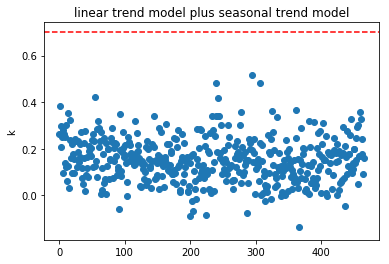

In [98]:
samples = fit_linear_trend.extract(permuted=True)
log_lik=samples['log_lik']
loo, loos, ks = psis.psisloo(log_lik)
m3_loo=loo
m3_loos=loos
print('sum of the LOO log densities: ',loo)
se=np.std(loos)*np.sqrt(months.shape[0])
print('SE: ',se)
count=0
for k in ks:
    if k>0.7:
        count=count+1
print('number of ks which are greater than 0.7: ',count)
lppd=np.sum (np.log (np.mean(np.exp(log_lik),axis=0)))
print('estimated effective number of parameters in the model: ',lppd-loo)
plt.scatter(np.arange(ks.shape[0]),ks)
plt.axhline(0.7, color='r',linestyle='dashed')
plt.ylabel('k')
plt.title('linear trend model plus seasonal trend model')
plt.show()

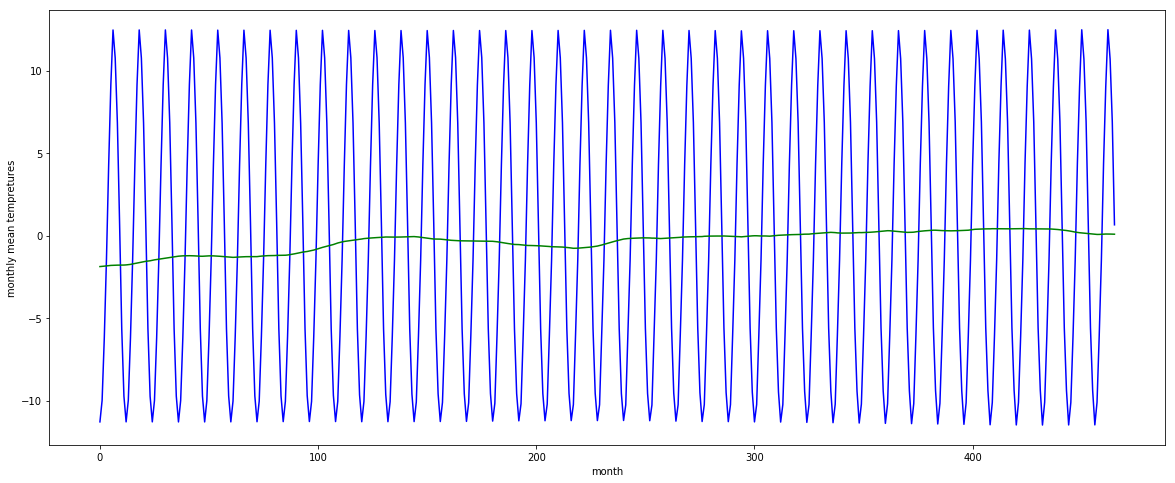

In [99]:
samples = fit_linear_trend.extract(permuted=True)
fig,ax=plt.subplots(figsize=(20,8))
ax.plot(np.mean(samples['seasonal_trend'],axis=0),color='b');
ax.plot(np.mean(samples['linear_trend'],axis=0),color='g');
ax.set_ylabel('monthly mean tempretures')
ax.set_xlabel('month')
plt.show()

In [100]:
inference_data_linear_trend = az.from_pystan(fit=fit_linear_trend,
                      posterior_predictive='y_hat',
                      observed_data=['y'],
                      log_likelihood='log_lik',
                      coords={'months': np.arange(months.shape[0])},
                      dims={'delta': ['months'],
                            'linear_trend': ['months'],
                            'seasonal_trend': ['months']
                            })

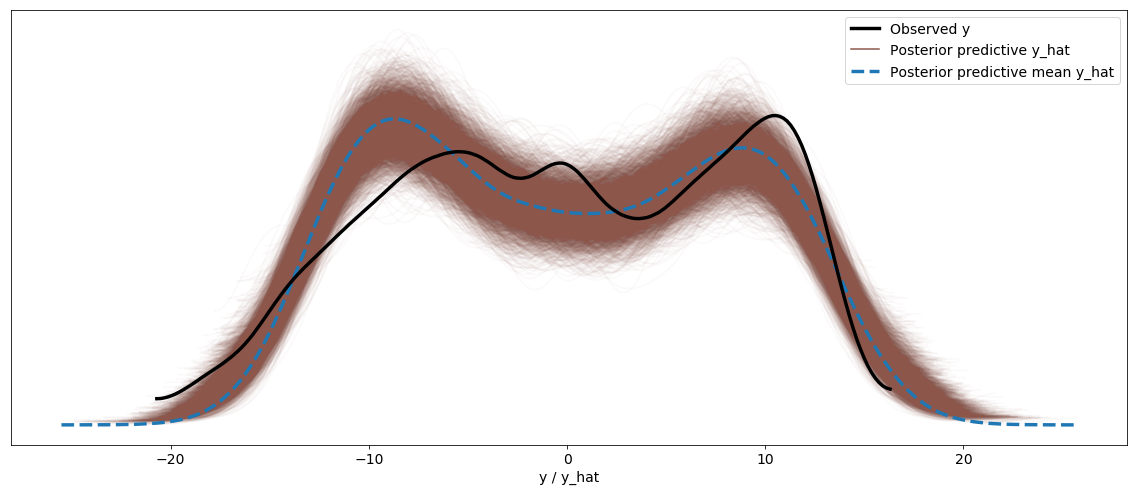

In [105]:
#Posterior Predictive Check Plot
az.plot_ppc(inference_data_linear_trend, alpha=0.03, figsize=(20, 8), textsize=14,data_pairs={'y' : 'y_hat'})
plt.show()

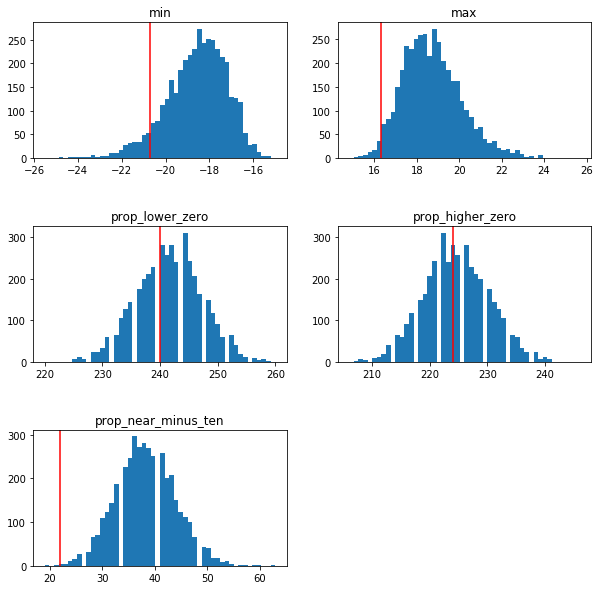

In [107]:
num_higher_zeros=0
num_lower_zeros=0
num_near_minus_ten=0
for t in tempretures:
    if t>0:
        num_higher_zeros=num_higher_zeros+1
    if t<0:
        num_lower_zeros=num_lower_zeros+1
    if t>-11 and t<-9:
        num_near_minus_ten=num_near_minus_ten+1
fig,axes=plt.subplots(3,2,figsize=(10,10))
samples = fit_linear_trend.extract(permuted=True)
axes[0,0].hist(samples['y_hat_min'],bins=50)
axes[0,0].axvline(np.min(tempretures),color='r')
axes[0,0].set_title('min')
axes[0,1].hist(samples['y_hat_max'],bins=50)
axes[0,1].axvline(np.max(tempretures),color='r')
axes[0,1].set_title('max')
axes[1,0].hist(samples['y_hat_prop_lower_zero'],bins=50)
axes[1,0].axvline(num_lower_zeros,color='r')
axes[1,0].set_title('prop_lower_zero')
axes[1,1].hist(samples['y_hat_prop_higher_zero'],bins=50)
axes[1,1].axvline(num_higher_zeros,color='r')
axes[1,1].set_title('prop_higher_zero')
axes[2,0].hist(samples['y_hat_prop_near_minus_ten'],bins=50)
axes[2,0].axvline(num_near_minus_ten,color='r')
axes[2,0].set_title('prop_near_minus_ten')
axes[2,1].set_axis_off()
plt.subplots_adjust(hspace=0.5)
plt.show()

<h2>Comparing three models</h2>

All the models did not have any Parato k values higher than 0.7, which mean we can use psis_loo for comparision because its estimates are reliable. 

In [117]:
#negative 'elpd_diff' favors linear regression plus seasonal trend model, positive favors local level plus seasonal trend model
elpd_diff=np.sum(m2_loos-m1_loos)
se=np.std(m2_loos-m1_loos)*np.sqrt(months.shape[0])
if elpd_diff<0:
    print('elpd_diff: ',elpd_diff)
    print('se: ',se)
    print('linear regression plus seasonal trend model should be selected')
else:
    print('elpd_diff: ',elpd_diff)
    print('se: ',se)
    print('local level plus seasonal trend model should be selected')

elpd_diff:  0.9107333888815816
se:  1.8180507480064345
local level plus seasonal trend model should be selected


In [118]:
#negative 'elpd_diff' favors local level plus seasonal trend model, positive favors local linear trend plus seasonal trend model
elpd_diff=np.sum(m3_loos-m2_loos)
se=np.std(m3_loos-m2_loos)*np.sqrt(months.shape[0])
if elpd_diff<0:
    print('elpd_diff: ',elpd_diff)
    print('se: ',se)
    print('local level plus seasonal trend model should be selected')
else:
    print('elpd_diff: ',elpd_diff)
    print('se: ',se)
    print('local linear trend plus seasonal trend model should be selected')

elpd_diff:  -0.7567381399667292
se:  0.3879774934855814
local level plus seasonal trend model should be selected


"elpd_diff" is small, so there is not that much difference between three models.The reason behind that is the original data is not that much complex and it seems a stationary time series without obvious increase or decrease over time. "ncp_local_level_seasonal_trend" model works sightly better than the two others.

<h2>Separate and hierarchical molde for multiple stations in north of Finland</h2> 
In the next section we use separate and hierarchical model with "local level plus seasonal trend" as the basis model.

1 466
1 932
1 1398
1 1864
(4, 466)
(4, 466)


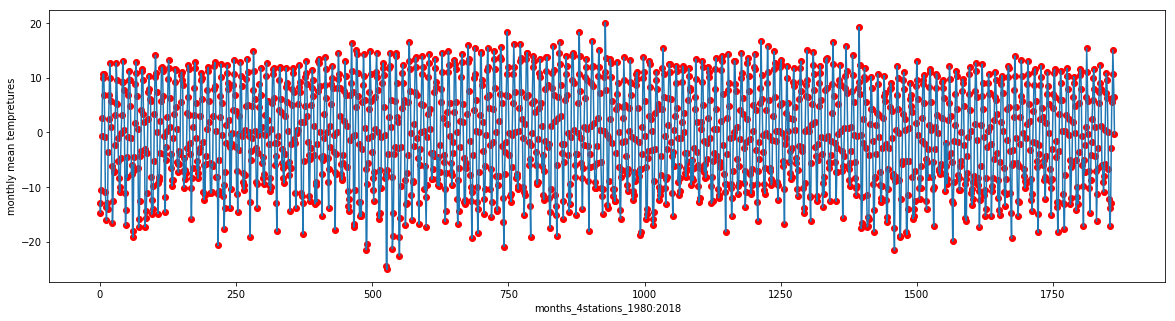

In [32]:
months=[]
tempretures1=[]
identicator=[]
count=0
count2=0
for line in open('UtsjokiNuorgam_monthly_1980_2018_complete.csv'):
    try:
        tempretures1.append(float(line.split(',')[3]))
        identicator.append(1)
        months.append(count)
    except ValueError:
        count2=count2+1
        pass
    count=count+1
print(count2,len(months))
count3=0
tempretures2=[]
for line in open('SodankyläTähtelä_monthly_1980_2018_complete.csv'):
    try:
        tempretures2.append(float(line.split(',')[3]))
        identicator.append(2)
        months.append(count)
    except ValueError:
        count3=count3+1
        pass
    count=count+1
print(count3,len(months))
count4=0
tempretures3=[]
for line in open('SallaVärriötunturi_monthly_1980_2018_complete.csv'):
    try:
        tempretures3.append(float(line.split(',')[3]))
        identicator.append(3)
        months.append(count)
    except ValueError:
        count4=count4+1
        pass
    count=count+1
print(count4,len(months))    
count5=0
tempretures4=[]
for line in open('EnontekiöKilpisjärviKyläkeskus_monthly_1980_2018_complete.csv'):
    try:
        tempretures4.append(float(line.split(',')[3]))
        identicator.append(4)
        months.append(count)
    except ValueError:
        count5=count5+1
        pass
    count=count+1
print(count5,len(months))

months=np.array(months)
tempretures=np.vstack((tempretures1,tempretures2,tempretures3,tempretures4))
months=np.vstack((np.arange(1,467),np.arange(1,467),np.arange(1,467),np.arange(1,467)))
print(tempretures.shape)
print(months.shape)

fig,ax=plt.subplots(figsize=(20,5))
y_=np.reshape(tempretures,(tempretures.shape[0]*tempretures.shape[1]))
ax.scatter(np.arange(y_.shape[0]),y_,c='r')
ax.plot(np.arange(y_.shape[0]),y_)
ax.set_ylabel('monthly mean tempretures')
ax.set_xlabel('months_4stations_1980:2018')
plt.show()

<h2>Separet model using local level plus seasonal trend </h2> 
In the next section we use separate model with "local level plus seasonal trend" as the basis model.

In [132]:
with open('separate_linear_regression_ncp_seasonal_trend.stan') as file:
    print(file.read())

data {
  int<lower=0> T;
  int<lower=0> K;	//number of stations
  matrix[K,T] y;
  int<lower=0> season_whithin_period;
}
parameters {
matrix[K,T] seasonal_trend_raw;
matrix[K,T] mu_raw;
real<lower=0> tau2;
real<lower=0> tau3;
vector<lower=0>[K] sigma;
matrix[K,11] seasonal_trend_init;
vector[K] mu_init;
}
transformed parameters {
matrix[K,T] seasonal_trend;
matrix[K,T] mu;
seasonal_trend[1:K,1:season_whithin_period-1]=seasonal_trend_init[1:K,1:season_whithin_period-1]+tau2*seasonal_trend_raw[1:K,1:season_whithin_period-1];
for (i in season_whithin_period:T){
	for(k in 1:K){
	seasonal_trend[k,i] = -seasonal_trend[k,i-1]-seasonal_trend[k,i-2]-seasonal_trend[k,i-3]-seasonal_trend[k,i-4]-seasonal_trend[k,i-5]-seasonal_trend[k,i-6]-seasonal_trend[k,i-7]-seasonal_trend[k,i-8]-seasonal_trend[k,i-9]-seasonal_trend[k,i-10]-seasonal_trend[k,i-11]+ tau2*seasonal_trend_raw[k,i];
	}
}
mu[1:K,1]=mu_init[1:K]+tau3*mu_raw[1:K,1];
for (t in 2:T)
	mu[1:K,t] =mu[1:K,t-1]+tau3*mu_raw[1:K,t];
}
model {
for

In [4]:
data_separate = dict(T=months.shape[1], y=tempretures,season_whithin_period=12,K=4)

model_separate = stan_utility.compile_model('separate_linear_regression_ncp_seasonal_trend.stan')

fit_separate = model_separate.sampling(data=data_separate, seed=194838,control={'max_treedepth':15})

In [43]:
check_hmc_diagnostics(fit_separate)

{'Rhat': True,
 'divergence': True,
 'energy': True,
 'n_eff': True,
 'treedepth': True}

In [135]:
stan_utility.check_treedepth(fit_separate)
stan_utility.check_energy(fit_separate)
stan_utility.check_div(fit_separate)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


sum of the LOO log densities:  -4505.365713083991
SE:  1.9001374632307948
number of ks which are greater than 0.7:  0
estimated effective number of parameters in the model:  84.4946699883958


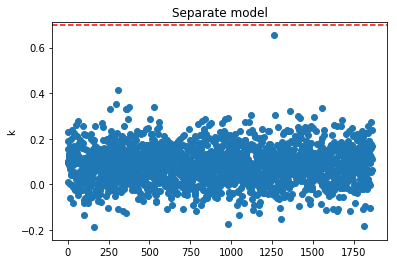

In [136]:
samples = fit_separate.extract(permuted=True)
log_lik=samples['log_lik']
log_lik=np.reshape(log_lik,(log_lik.shape[0],log_lik.shape[1]*log_lik.shape[2]))
loo, loos, ks = psis.psisloo(log_lik)
s_loo=loo
s_loos=loos
print('sum of the LOO log densities: ',loo)
se=np.std(loos)*np.sqrt(months.shape[0])
print('SE: ',se)
count=0
for k in ks:
    if k>0.7:
        count=count+1
print('number of ks which are greater than 0.7: ',count)
lppd=np.sum (np.log (np.mean(np.exp(log_lik),axis=0)))
print('estimated effective number of parameters in the model: ',lppd-loo)
plt.scatter(np.arange(ks.shape[0]),ks)
plt.axhline(0.7, color='r',linestyle='dashed')
plt.ylabel('k')
plt.title('Separate model')
plt.show()

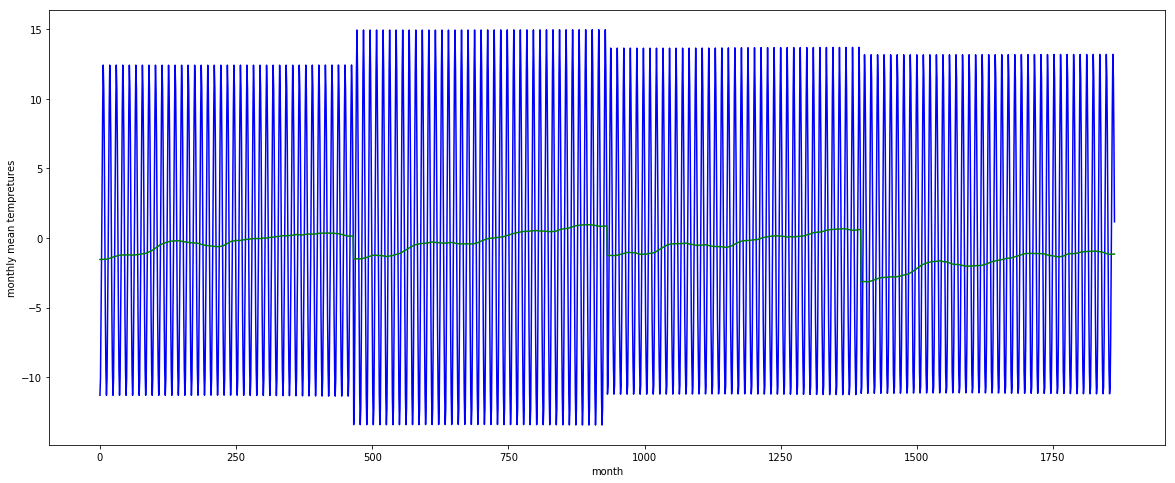

In [137]:
samples = fit_separate.extract(permuted=True)
fig,ax=plt.subplots(figsize=(20,8))
seasonal_trend=samples['seasonal_trend']
mu=samples['mu']
ax.plot(np.mean(np.reshape(seasonal_trend,(seasonal_trend.shape[0],seasonal_trend.shape[1]*seasonal_trend.shape[2])),axis=0),color='b');
ax.plot(np.mean(np.reshape(mu,(mu.shape[0],mu.shape[1]*mu.shape[2])),axis=0),color='g');
ax.set_ylabel('monthly mean tempretures')
ax.set_xlabel('month')
plt.show()

In [138]:
inference_data_separate = az.from_pystan(fit=fit_separate,
                      posterior_predictive='y_hat',
                      observed_data=['y'],
                      log_likelihood='log_lik',
                      coords={'stations':np.arange(months.shape[0]),'months': np.arange(months.shape[1])},
                      dims={'mu': ['stations','months'],
                            'seasonal_trend': ['stations','months']
                            })

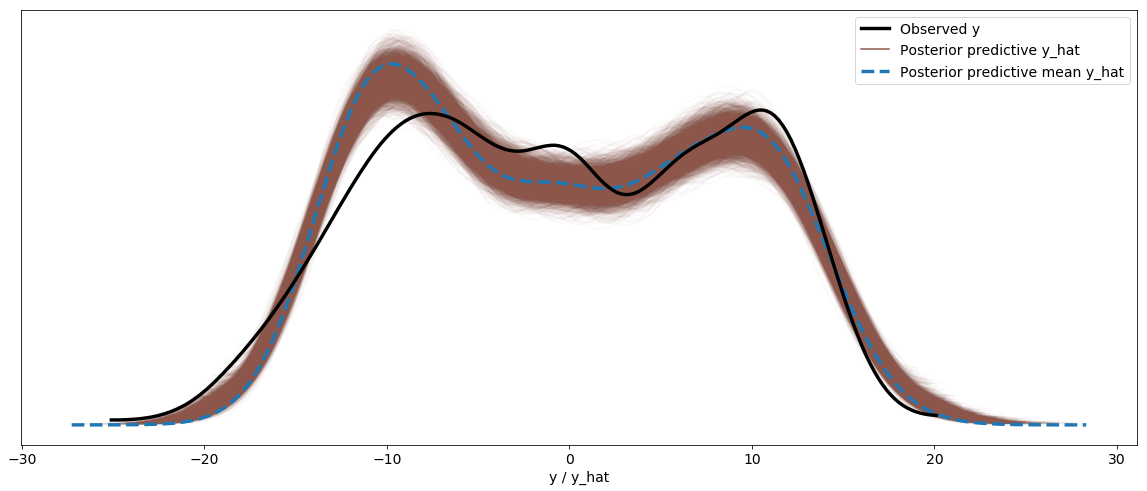

In [143]:
#Posterior Predictive Check Plot
az.plot_ppc(inference_data_separate, alpha=0.03, figsize=(20, 8), textsize=14,data_pairs={'y' : 'y_hat'})
plt.show()

<h2>Hierarchical model using local level plus seasonal trend </h2> 
In the next section we use hierarchical model with "local level plus seasonal trend" as the basis model.

In [33]:
with open('hierarchical_linear_regression_ncp_seasonal_trend.stan') as file:
    print(file.read())

data {
  int<lower=0> T;
  int<lower=0> K;	//number of stations
  matrix[K,T] y;
  int<lower=0> season_whithin_period;
}
parameters {
matrix[K,T] mu_group;
real <lower=0> tau;
vector[T] seasonal_trend_raw;
vector[T] mu_raw;
real<lower=0> tau2;
real<lower=0> tau3;
real<lower=0> sigma;
vector[11] seasonal_trend_init;
real mu_init;
}
transformed parameters {
vector[T] seasonal_trend;
vector[T] mu;
seasonal_trend[1:season_whithin_period-1]=seasonal_trend_init[1:season_whithin_period-1]+tau2*seasonal_trend_raw[1:season_whithin_period-1];
for (i in season_whithin_period:T){
	seasonal_trend[i] = -seasonal_trend[i-1]-seasonal_trend[i-2]-seasonal_trend[i-3]-seasonal_trend[i-4]-seasonal_trend[i-5]-seasonal_trend[i-6]-seasonal_trend[i-7]-seasonal_trend[i-8]-seasonal_trend[i-9]-seasonal_trend[i-10]-seasonal_trend[i-11]+ tau2*seasonal_trend_raw[i];
}
mu[1]=mu_init+tau3*mu_raw[1];
for (t in 2:T)
	mu[t] =mu[t-1]+tau3*mu_raw[t];
}
model {
for (t in 1:T){
	for(k in 1:K){
		mu_group[k,t] ~ normal(mu[t]+

In [40]:
data_hierarchical = dict(T=months.shape[1], y=tempretures,season_whithin_period=12,K=4)

model_hierarchical = stan_utility.compile_model('hierarchical_linear_regression_ncp_seasonal_trend.stan')

fit_hierarchical = model_hierarchical.sampling(data=data_hierarchical, seed=194838,control={'max_treedepth':15})

In [39]:
check_hmc_diagnostics(fit_hierarchical,verbose =False)

{'Rhat': False,
 'divergence': False,
 'energy': False,
 'n_eff': False,
 'treedepth': False}

This model had lots of warnings, but because the size of the notebook became large, we did not show them here.

In [36]:
stan_utility.check_treedepth(fit_hierarchical)
stan_utility.check_energy(fit_hierarchical)
stan_utility.check_div(fit_hierarchical)

548 of 4000 iterations saturated the maximum tree depth of 10 (13.7%)
Run again with max_depth set to a larger value to avoid saturation
Chain 0: E-BFMI = 0.03459295464685048
E-BFMI below 0.2 indicates you may need to reparameterize your model
Chain 1: E-BFMI = 0.1413459172326072
E-BFMI below 0.2 indicates you may need to reparameterize your model
Chain 2: E-BFMI = 0.02089944255682758
E-BFMI below 0.2 indicates you may need to reparameterize your model
Chain 3: E-BFMI = 0.03720428853486046
E-BFMI below 0.2 indicates you may need to reparameterize your model
42.0 of 4000 iterations ended with a divergence (1.05%)
Try running with larger adapt_delta to remove the divergences


In [37]:
inference_data_hierarchical = az.from_pystan(fit=fit_hierarchical,
                      posterior_predictive='y_hat',
                      observed_data=['y'],
                      log_likelihood='log_lik',
                      coords={'stations':np.arange(months.shape[0]),'months': np.arange(months.shape[1])},
                      dims={'mu_group': ['stations','months']
                            })

sum of the LOO log densities:  -3344.6753297670757
SE:  2.779244609018802
number of ks which are greater than 0.7:  1177
estimated effective number of parameters in the model:  1460.2847715185478


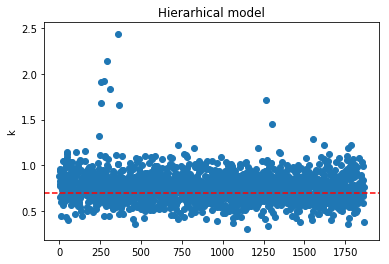

In [38]:
samples = fit_hierarchical.extract(permuted=True)
log_lik=samples['log_lik']
log_lik=np.reshape(log_lik,(log_lik.shape[0],log_lik.shape[1]*log_lik.shape[2]))
loo, loos, ks = psis.psisloo(log_lik)
h_loo=loo
h_loos=loos
print('sum of the LOO log densities: ',loo)
se=np.std(loos)*np.sqrt(months.shape[0])
print('SE: ',se)
count=0
for k in ks:
    if k>0.7:
        count=count+1
print('number of ks which are greater than 0.7: ',count)
lppd=np.sum (np.log (np.mean(np.exp(log_lik),axis=0)))
print('estimated effective number of parameters in the model: ',lppd-loo)
plt.scatter(np.arange(ks.shape[0]),ks)
plt.axhline(0.7, color='r',linestyle='dashed')
plt.ylabel('k')
plt.title('Hierarhical model')
plt.show()

Because hierarchical model has lots of Parato k values larger than 0.7, psis_loo estimates are not reliable and we could not compare it with separate model.

<h1>Conclusion</h1>
Here we proposed different models for trend analysis of time series dataset. We provided posterior predictive check and model comparison. For proposing any bayesian model, you should be aware of your dataset and with the knowledge of the dataset select priors for parameters. It is better to use weakely informative priors except you are certain about the distribution of parameters. I think for the next step, we should make the hierarchical model works. It is good to see  how multi dimensional time series work then instead of just tempretures we can take pericipitation and other factors into account.